In this file we will work the data and prepare it for the modeling phase.

## Import Libraries

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from datetime import datetime,timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from sklearn.preprocessing import MinMaxScaler
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from keras.preprocessing.sequence import pad_sequences

## Load Data

### News

In [20]:
# Reddit Data
df_Crypto_Currency_News = pd.read_csv('../Load/Reddit/comments/Crypto_Currency_News_comments.csv')
df_CryptoCurrencies = pd.read_csv('../Load/Reddit/comments/CryptoCurrencies_comments.csv')
df_CryptoCurrency = pd.read_csv('../Load/Reddit/comments/CryptoCurrency_comments.csv')
df_Cryptomarkets = pd.read_csv('../Load/Reddit/comments/Cryptomarkets_comments.csv')
df_eth = pd.read_csv('../Load/Reddit/comments/eth_comments.csv')
df_ethfinance = pd.read_csv('../Load/Reddit/comments/ethfinance_comments.csv')
df_ethtrader = pd.read_csv('../Load/Reddit/comments/ethtrader_comments.csv')

df_reddit = [df_Crypto_Currency_News, df_CryptoCurrencies, df_CryptoCurrency, df_Cryptomarkets, df_eth, df_ethfinance, df_ethtrader]

### Financial Data

In [21]:
# Yahoo Data
df_yahoo = pd.read_csv('../Load/datasets/Yahoo/ETH-USD.csv', delimiter=';')
# Binanace Data
df_BNB_ETH = pd.read_csv('../Load/datasets/Binance/BNB-ETH-klines.csv', delimiter=';')
df_ETH_BTC = pd.read_csv('../Load/datasets/Binance/ETH-BTC-klines.csv', delimiter=';')
df_ETH_USDT = pd.read_csv('../Load/datasets/Binance/ETH-USDT-klines.csv', delimiter=';')
df_XRP_ETH = pd.read_csv('../Load/datasets/Binance/XRP-ETH-klines.csv', delimiter=';')

df_binance = [df_ETH_USDT, df_ETH_BTC, df_BNB_ETH, df_XRP_ETH]

## Transform Dataframes

### Reddit

In [22]:
for df in df_reddit:
    # Drop columns we don't need
    df.drop(['id', 'num_comments', 'permalink', 'score', 'subreddit'], axis=1, inplace=True)
    # Change created_utc format to day/month/year
    df['date'] = pd.to_datetime(df['created_utc'])
    df['date'] = df['date'].dt.strftime('%#d/%#m/%Y')
    # Join title and comments into one column
    # if a comment is empty, replace it with an empty string
    df['title'] = df['title'].astype(str)
    df['comment_1'].fillna('', inplace=True)
    df['comment_1'] = df['comment_1'].astype(str)
    df['comment_2'].fillna('', inplace=True)
    df['comment_2'] = df['comment_2'].astype(str)
    df['comment_3'].fillna('', inplace=True)
    df['comment_3'] = df['comment_3'].astype(str)
    # We use <sos> and <eos> to mark the start and end of a text, this will help training the model
    df['text'] = 'SOS ' + df['title'] + '. ' + df['comment_1'] + '. ' + df['comment_2'] + '. ' + df['comment_3'] + ' EOS'
    # Drop columns
    df.drop(['created_utc','title', 'comment_1', 'comment_2', 'comment_3'], axis=1, inplace=True)
    
pd.set_option('display.max_rows', None)
df_Crypto_Currency_News.head(11)

,date,text
0,1/10/2019,SOS Divi Project Update September 2019 Month i...
1,1/10/2019,SOS Interview with the CEO of DIVI Geoff McCab...
2,1/10/2019,SOS Is Wall Street Finally Learning Not To Pan...
3,1/10/2019,"SOS In China, a large mining farm burned down...."
4,1/10/2019,SOS Bitcoin Bull Run's 'Likely Target' is $200...
5,1/10/2019,"SOS Vaultoro Integrates Dash, Relaunches Gold-..."
6,1/10/2019,SOS Flixxo's latest article on LATAM Bonds. . ...
7,1/10/2019,SOS Block.One agrees to pay SEC $24 million ov...
8,1/10/2019,SOS Altcoin News: Shady CoinExchange.io Is Clo...
9,1/10/2019,SOS Which cryptocurrency do you think will win...


Make a list of all the Dates in our Range

In [23]:
start_date = datetime.strptime("1/10/2019","%d/%m/%Y")
end_date = datetime.strptime("30/9/2022","%d/%m/%Y")

# This will create a list with complete dates
completeDates = [start_date + timedelta(days=x) for x in range(0,(end_date-start_date ).days + 1)]
# reformat completeDates from 2019-10-01 00:00:00 to 1/10/2019
completeDates = [date.strftime('%#d/%#m/%Y') for date in completeDates]

Reshape Reddit Dataframes to have one row per Date, with a column for each text

In [24]:
# create dummy dataframes for the 7 reddit dataframes
columns = ['date', 'text_1', 'text_2', 'text_3', 'text_4', 'text_5', 'text_6', 'text_7', 'text_8', 'text_9', 'text_10']
df_Crypto_Currency_News_f = pd.DataFrame(columns=columns)
df_CryptoCurrencies_f = pd.DataFrame(columns=columns)
df_CryptoCurrency_f = pd.DataFrame(columns=columns)
df_Cryptomarkets_f = pd.DataFrame(columns=columns)
df_eth_f = pd.DataFrame(columns=columns)
df_ethfinance_f = pd.DataFrame(columns=columns)
df_ethtrader_f = pd.DataFrame(columns=columns)

# create list of dataframes
df_reddit_f = [df_Crypto_Currency_News_f, df_CryptoCurrencies_f, df_CryptoCurrency_f, df_Cryptomarkets_f, df_eth_f, df_ethfinance_f, df_ethtrader_f]

# get dates from completeDates list
for df in df_reddit_f:
    df['date'] = completeDates

df_Crypto_Currency_News_f.head(3)

,date,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9,text_10
0,1/10/2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2/10/2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3/10/2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Should take around 40 seconds
for i, df in enumerate(df_reddit):
    for day in completeDates:
        df_day = df.loc[df['date'] == day].reset_index(drop=True)
        # get the number of rows
        df_day_len = len(df_day)
        # if there are rows
        if df_day_len > 0:
            for j in range(0, df_day_len):
                text = df_day['text'][j]
                column = 'text_' + str(j+1)
                index = df_reddit_f[i].index[df_reddit_f[i]['date'] == day].values[0]
                df_reddit_f[i].at[index, column] = text

In [26]:
# Remove extra Nan columns
df_reddit_f[2].drop(['text_11', 'text_12', 'text_13'], axis=1, inplace=True)
df_reddit_f[5].drop(['text_11'], axis=1, inplace=True)

In [27]:
for df in df_reddit_f:
    print(df.shape)

(1096, 11)
(1096, 11)
(1096, 11)
(1096, 11)
(1096, 11)
(1096, 11)
(1096, 11)


In [28]:
# For the resulting dataframes, set date as index
for df in df_reddit_f:
    df.set_index('date', inplace=True)

In [29]:
# verify that all dataframes have all the dates
for df in df_reddit_f:
    myDates = df.index.tolist()
    myDates = [d.split()[0] for d in myDates]
    missingDates = [d for d in completeDates if d not in myDates]
    print(len(missingDates))


0
0
0
0
0
0
0


In [30]:
# Lets see the final results of one dataframe
df_Crypto_Currency_News_f.head(2)

,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9,text_10
date,,,,,,,,,,
1/10/2019,SOS Divi Project Update September 2019 Month i...,SOS Interview with the CEO of DIVI Geoff McCab...,SOS Is Wall Street Finally Learning Not To Pan...,"SOS In China, a large mining farm burned down....",SOS Bitcoin Bull Run's 'Likely Target' is $200...,"SOS Vaultoro Integrates Dash, Relaunches Gold-...",SOS Flixxo's latest article on LATAM Bonds. . ...,SOS Block.One agrees to pay SEC $24 million ov...,SOS Altcoin News: Shady CoinExchange.io Is Clo...,SOS Which cryptocurrency do you think will win...
2/10/2019,SOS Popular Ethereum App Collapses: How Many O...,SOS Top German Bank Predicts Bitcoin to Hit $9...,SOS UTRUST Integrates Dash Enabling Cryptocurr...,SOS Brazilian Cryptocurrency Exchange Cointrad...,SOS Samsung-Backed Blocko Launches in UAE Afte...,SOS Speaker of the House Challenger Bacelar ha...,SOS Altcoin News: A Large German Bank Predicts...,SOS Trustee of Mt.Gox Is Interested in the Cas...,SOS HONG KONG: Why Bitcoin volumes have hit a ...,SOS US State of Ohio Suspends Service for Payi...


In [31]:
df_Crypto_Currency_News_f.tail(2)

,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9,text_10
date,,,,,,,,,,
29/9/2022,SOS Upvote For Upvote. Can Bitcoin break the r...,SOS Audius (AUDIO) Decentralized Music Platfor...,"SOS Smoke Session! Comment ""puff"" for your Ste...",SOS Binance Launches Training Program for Gove...,SOS Ribbon Finance has launches ETH-Based Cryp...,SOS ECB Advisor Defends Amazonâ€™s Role in Dig...,SOS Brazilâ€™s Securities Market Regulator Tar...,SOS win free virtual land on Metaverse. . . EOS,SOS ChainPort adds support for Aurora EVM. The...,SOS Project for cross-chain bitcoin transfers ...
30/9/2022,SOS Crypto Miners are Ready for the Future. . ...,SOS OKX Reddit Giveaway | You're in ?. . . EOS,SOS MicroStrategy Looks to Hire Software Engin...,SOS MetaMask Launches New All-In-One Digital A...,SOS How to make MONEY online for FREE in 2022?...,SOS Crypto Underworld â€“ Where Crypto Profits...,SOS Unique Girls - NFT. . . EOS,SOS TOP METAVERSE DEVELOPMENT USE CASES PREFER...,SOS ONI is available on Guarda wallet. You can...,SOS PolkaStation. . . EOS


In [32]:
# count the average number of words per text and print it
for df in df_reddit_f:
    words = []
    for i in range(1,11):
        column = 'text_' + str(i)
        words.append(df[column].str.split().str.len())
    words = pd.concat(words, axis=1)
    words['avg_words'] = words.mean(axis=1)
    print(words['avg_words'].mean())

18.889004029936675
24.123721176782404
71.79755425979917
27.04819624819625
39.583858998144706
75.10511930553713
45.128344671201816


In [33]:
# check for empty values
df_Crypto_Currency_News_f.isnull().sum()

text_1     131
text_2     131
text_3     131
text_4     132
text_5     133
text_6     133
text_7     133
text_8     134
text_9     134
text_10    135
dtype: int64

In [34]:
# If we don't have news for a day, it is most likely that the sentiment is the same as the previous day
# so we yse ffill to fill empty text values with the previous value
for df in df_reddit_f:
    df.fillna(method='ffill', inplace=True)


In [35]:
df_Crypto_Currency_News_f.isnull().sum()

text_1     0
text_2     0
text_3     0
text_4     0
text_5     0
text_6     0
text_7     0
text_8     0
text_9     0
text_10    0
dtype: int64

In [36]:
# export all 7 dataframes to csv in folder preprocessed_news, will use them in dictionary.ipynb
df_Crypto_Currency_News_f.to_csv('preprocessed_news/Crypto_Currency_News_f.csv')
df_CryptoCurrencies_f.to_csv('preprocessed_news/CryptoCurrencies_f.csv')
df_CryptoCurrency_f.to_csv('preprocessed_news/CryptoCurrency_f.csv')
df_Cryptomarkets_f.to_csv('preprocessed_news/Cryptomarkets_f.csv')
df_eth_f.to_csv('preprocessed_news/eth_f.csv')
df_ethfinance_f.to_csv('preprocessed_news/ethfinance_f.csv')
df_ethtrader_f.to_csv('preprocessed_news/ethtrader_f.csv')

### Yahoo & Binance

In [37]:
# No changes needded for Yahoo data
df_yahoo.head()

,date,adj_close,volume
0,1/10/2019,177.340424,7676276225
1,2/10/2019,180.710510,6335595250
2,3/10/2019,175.199341,6381403725
3,4/10/2019,176.985001,6248928449
4,5/10/2019,176.351517,5837211771


In [38]:
for df in df_binance:
    # Drop columns we don't need
    df.drop(['quote_asset_volume', 'taker_buy_quote_asset_volume'], axis=1, inplace=True)
    # For df_ETH_USDT we also drop close, as we have the equivalent in df_yahoo
    if df is df_ETH_USDT:
        df.drop(['close'], axis=1, inplace=True)

# Rename columns
df_ETH_USDT.rename(columns={'num_trades':'num_trades_USDT'}, inplace=True)

df_ETH_BTC.rename(columns={'close':'close_BTC'}, inplace=True)
df_ETH_BTC.rename(columns={'num_trades':'num_trades_BTC'}, inplace=True)

df_BNB_ETH.rename(columns={'close':'close_BNB'}, inplace=True)
df_BNB_ETH.rename(columns={'num_trades':'num_trades_BNB'}, inplace=True)

df_XRP_ETH.rename(columns={'close':'close_XRP'}, inplace=True)
df_XRP_ETH.rename(columns={'num_trades':'num_trades_XRP'}, inplace=True)
# Fix XRP_ETH date format from 01/09/2019 to 1/9/2019
df_XRP_ETH['date'] = df_XRP_ETH['date'].str.replace(r'\b0(\d{1})', r'\1')

df_XRP_ETH.head()

,date,close_XRP,num_trades_XRP
0,1/10/2019,0.001410,5946.0
1,2/10/2019,0.001401,5689.0
2,3/10/2019,0.001413,4310.0
3,4/10/2019,0.001439,4729.0
4,5/10/2019,0.001437,4356.0


In [39]:
# Join yahoo and binance dataframes on equal dates
df_finance = pd.merge(df_yahoo, df_ETH_USDT, on='date', how='left')
df_finance = pd.merge(df_finance, df_ETH_BTC, on='date', how='left')
df_finance = pd.merge(df_finance, df_BNB_ETH, on='date', how='left')
df_finance = pd.merge(df_finance, df_XRP_ETH, on='date', how='left')

# in case any dates duplicate, we drop them
df_finance.drop_duplicates(subset='date', keep='first', inplace=True)

# set date as index
df_finance.set_index('date', inplace=True)
df_finance.index = pd.to_datetime(df_finance.index, format="%d/%m/%Y")

df_finance.head()

,adj_close,volume,num_trades_USDT,close_BTC,num_trades_BTC,close_BNB,num_trades_BNB,close_XRP,num_trades_XRP
date,,,,,,,,,
2019-10-01,177.340424,7676276225,168492,0.021182,133240,0.090262,11802,0.001410,5946.0
2019-10-02,180.710510,6335595250,96660,0.021566,92471,0.088028,7465,0.001401,5689.0
2019-10-03,175.199341,6381403725,101114,0.021241,87748,0.089504,7160,0.001413,4310.0
2019-10-04,176.985001,6248928449,89655,0.021580,87725,0.089029,6246,0.001439,4729.0
2019-10-05,176.351517,5837211771,90341,0.021682,93049,0.089143,5373,0.001437,4356.0


In [40]:
# verify that all dates are present
myDates = df_finance.index.tolist()
myDates = [d.strftime('%#d/%#m/%Y') for d in myDates]
missingDates = [d for d in completeDates if d not in myDates]
print(len(missingDates))

0


#### Explaining vairables
**closes**
- adj_close and close_BTC is the price of ETH relative to USD and BTC respectively. If adj_close = 1328 and close_BTC = 0.068, then 1 ETH is worth 1328 USD and 0.068 BTC.
- close_BNB and close_XRP is the price of BNB and XRP in ETH, the other way around. If close_BNB = 0.021 close_XRP = 0.00036, then 1 BNB is worth 0.021 ETH and 1 XRP is worth 0.00036 ETH.

**volume**
- Shows how much was traded on each exchange where ETH-USD is listed. It is an indicator of its popularity as well as market sentiment.

**num_trades**
- Number of trades is the number of trades that happened that day between ETH and the other coin in Binance

In [41]:
# check for empty values
df_finance.isnull().sum()

adj_close           0
volume              0
num_trades_USDT     0
close_BTC           0
num_trades_BTC      0
close_BNB           0
num_trades_BNB      0
close_XRP          61
num_trades_XRP     61
dtype: int64

In [42]:
# Fill empty values with interpolation, fills with the average of the previous and next values
df_finance['close_XRP'] = df_finance['close_XRP'].interpolate(method='time')
df_finance['num_trades_XRP'] = df_finance['num_trades_XRP'].interpolate(method='time')

In [43]:
df_finance.isnull().sum()

adj_close          0
volume             0
num_trades_USDT    0
close_BTC          0
num_trades_BTC     0
close_BNB          0
num_trades_BNB     0
close_XRP          0
num_trades_XRP     0
dtype: int64

In [44]:
# fix index format from 2019-10-01 to 1/10/2019
df_finance.index = df_finance.index.strftime('%#d/%#m/%Y')

In [45]:
df_finance.head()

,adj_close,volume,num_trades_USDT,close_BTC,num_trades_BTC,close_BNB,num_trades_BNB,close_XRP,num_trades_XRP
date,,,,,,,,,
1/10/2019,177.340424,7676276225,168492,0.021182,133240,0.090262,11802,0.001410,5946.0
2/10/2019,180.710510,6335595250,96660,0.021566,92471,0.088028,7465,0.001401,5689.0
3/10/2019,175.199341,6381403725,101114,0.021241,87748,0.089504,7160,0.001413,4310.0
4/10/2019,176.985001,6248928449,89655,0.021580,87725,0.089029,6246,0.001439,4729.0
5/10/2019,176.351517,5837211771,90341,0.021682,93049,0.089143,5373,0.001437,4356.0


In [46]:
df_finance.tail()

,adj_close,volume,num_trades_USDT,close_BTC,num_trades_BTC,close_BNB,num_trades_BNB,close_XRP,num_trades_XRP
date,,,,,,,,,
26/9/2022,1335.320190,16034549271,934159,0.069505,275490,0.2066,23684,0.000350,15980.0
27/9/2022,1330.127686,17870598937,1055212,0.069609,356483,0.2050,29137,0.000335,14991.0
28/9/2022,1337.410889,18994979566,1075441,0.068884,404236,0.2105,37346,0.000336,13145.0
29/9/2022,1335.652344,13796915736,950476,0.068188,325040,0.2126,29551,0.000365,17534.0
30/9/2022,1327.978638,14250100093,926935,0.068412,345607,0.2143,28865,0.000361,21250.0


In [47]:
df_finance.shape

(1096, 9)

## Data norlizaion

In [48]:
df_finance.describe()

,adj_close,volume,num_trades_USDT,close_BTC,num_trades_BTC,close_BNB,num_trades_BNB,close_XRP,num_trades_XRP
count,1096.000000,1.096000e+03,1.096000e+03,1096.000000,1.096000e+03,1096.000000,1096.000000,1096.000000,1096.000000
mean,1594.361223,1.874493e+10,8.064664e+05,0.047499,2.134119e+05,0.117950,31448.068431,0.000602,10667.083942
std,1338.158674,1.021700e+10,6.321341e+05,0.022036,1.324214e+05,0.044802,32269.369875,0.000437,12662.872251
min,110.605873,5.109033e+09,6.484700e+04,0.017371,5.807400e+04,0.030060,3083.000000,0.000189,1034.000000
25%,244.790188,1.208581e+10,2.864990e+05,0.025861,1.222092e+05,0.081192,12067.250000,0.000259,3823.250000
50%,1473.698608,1.651708e+10,7.192525e+05,0.039195,1.771750e+05,0.122350,21834.000000,0.000349,6889.000000
75%,2697.766052,2.257326e+10,1.116988e+06,0.069269,2.609598e+05,0.145918,36515.000000,0.000853,11900.000000
max,4812.087402,8.448291e+10,5.548968e+06,0.087910,1.201493e+06,0.279506,347271.000000,0.001723,142479.000000


We can see the following number ranges for each column:
- adj_close: 110.605873 to 4812.087402
- volume: 5.109033e+09 to 8.448291e+10 
- num_trades_USDT: 6.484700e+04 to 5.548968e+06
- [...]
- close_XRP: 0.000189	to 0.001723
- num_trades_XRP: 1034.000000 to 142479.000000

we have values going from 0.000189 to 8.448291e+10, 
it is a huge difference, we need to normalize the data.

In [49]:
scaler = MinMaxScaler()

# save in a new dataframe
df_finance_norm = pd.DataFrame(scaler.fit_transform(df_finance), columns=df_finance.columns, index=df_finance.index)

df_finance_norm.head()

,adj_close,volume,num_trades_USDT,close_BTC,num_trades_BTC,close_BNB,num_trades_BNB,close_XRP,num_trades_XRP
date,,,,,,,,,
1/10/2019,0.014194,0.032344,0.018899,0.054027,0.065738,0.241343,0.025332,0.796025,0.034727
2/10/2019,0.014911,0.015453,0.005801,0.059471,0.030083,0.232387,0.012731,0.790415,0.032910
3/10/2019,0.013739,0.016030,0.006613,0.054863,0.025952,0.238304,0.011845,0.798080,0.023161
4/10/2019,0.014119,0.014361,0.004524,0.059669,0.025932,0.236400,0.009190,0.815287,0.026123
5/10/2019,0.013984,0.009174,0.004649,0.061115,0.030588,0.236857,0.006653,0.813421,0.023486


In [50]:
# save the scaler so that we can use it later
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [51]:
# test the scaler

# load the scaler
scaler_loaded = pickle.load(open('scaler.pkl', 'rb'))

# copy the first 5 rows of df_finance into a new dataframe to test
df_finance_norm_test = df_finance.iloc[:5].copy()
# edit some rows of the new dataframe, 
# scaler should normalize the rest of the data the same way regardless of the difference in the data
df_finance_norm_test.iloc[1] = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
df_finance_norm_test.iloc[3] = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]

# use the scaler, should return the same values as df_finance_norm in rows other than the second and fourth
df_finance_norm_test = pd.DataFrame(scaler_loaded.transform(df_finance_norm_test), columns=df_finance_norm_test.columns, index=df_finance_norm_test.index)

df_finance_norm_test.head()

,adj_close,volume,num_trades_USDT,close_BTC,num_trades_BTC,close_BNB,num_trades_BNB,close_XRP,num_trades_XRP
date,,,,,,,,,
1/10/2019,0.014194,0.032344,0.018899,0.054027,0.065738,0.241343,0.025332,0.796025,0.034727
2/10/2019,-0.023419,-0.064367,-0.011824,6.842016,-0.050789,1.883935,-0.008956,326.017233,-0.007307
3/10/2019,0.013739,0.016030,0.006613,0.054863,0.025952,0.238304,0.011845,0.798080,0.023161
4/10/2019,-0.023483,-0.064367,-0.011824,2.589050,-0.050790,0.681270,-0.008957,130.332729,-0.007309
5/10/2019,0.013984,0.009174,0.004649,0.061115,0.030588,0.236857,0.006653,0.813421,0.023486


In [52]:
# now test reversing the normalization
df_finance_norm_test = pd.DataFrame(scaler_loaded.inverse_transform(df_finance_norm_test), columns=df_finance_norm_test.columns, index=df_finance_norm_test.index)

df_finance_norm_test.head()

,adj_close,volume,num_trades_USDT,close_BTC,num_trades_BTC,close_BNB,num_trades_BNB,close_XRP,num_trades_XRP
date,,,,,,,,,
1/10/2019,177.340424,7.676276e+09,168492.0,0.021182,133240.0,0.090262,11802.0,0.001410,5946.0
2/10/2019,0.500000,5.000005e-01,0.5,0.500000,0.5,0.500000,0.5,0.500000,0.5
3/10/2019,175.199341,6.381404e+09,101114.0,0.021241,87748.0,0.089504,7160.0,0.001413,4310.0
4/10/2019,0.200000,2.000000e-01,0.2,0.200000,0.2,0.200000,0.2,0.200000,0.2
5/10/2019,176.351517,5.837212e+09,90341.0,0.021682,93049.0,0.089143,5373.0,0.001437,4356.0


works just as expected

## Data Visualization

In [53]:
# Visualize the complete news from Crypto_Currency_News_f for a specific date
# These are very long strings
pd.set_option('display.max_colwidth', None)
df_eth_f.loc['1/10/2019']

text_1     SOS Gradbase putting qualifications on the Ethereum Blockchain. In my opinion I think this is a very solid use case.. This is indeed a very good use case of Blockchain technology in general.\n\nThe qualification verification procedures of today are dire. If you wanted to verify the authenticity of a degree or work experience you would in 99.9% of cases know who/what office to contact at the issuing institution. This is before you take into account the eventual language barrier and international payment that may have to be made. Moreover, every institution uses their own method (typically slow and manual) to accept requests and fulfil them. I've seen companies not perform employee checks at all because the system is simply impossible to navigate.\n\nThis is because there is zero standardisation in this sector, and all data is stored in different siloed databases at the institution's end.\n\nAt a talk in London, UK last year, Vitalik expressed his support for using Ethereum to

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

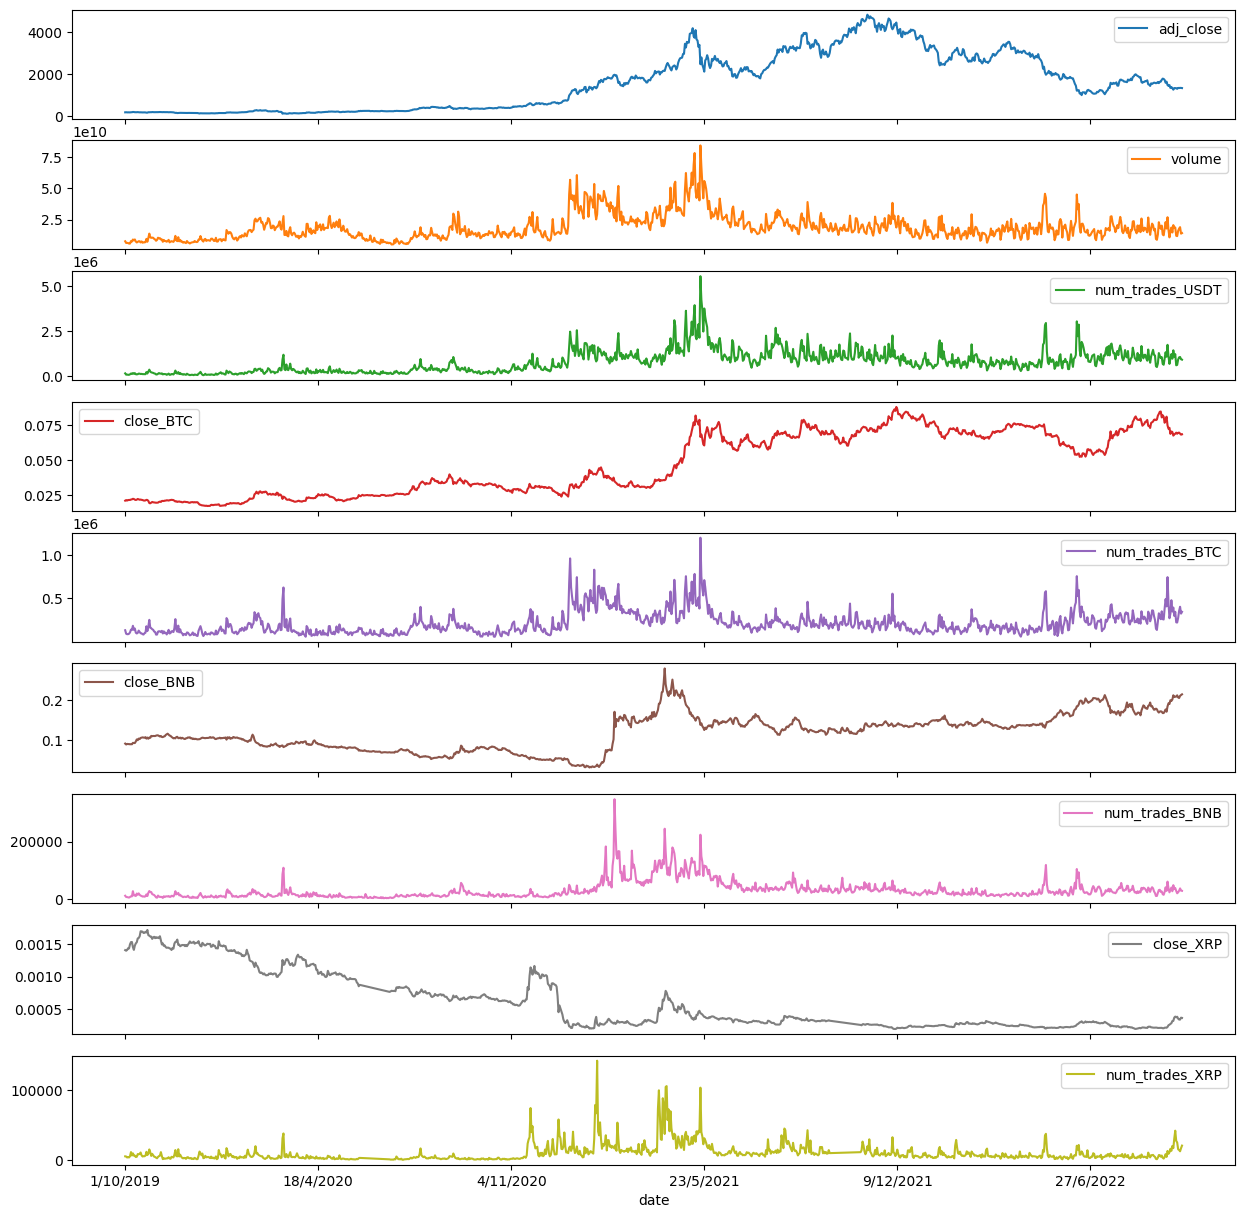

In [54]:
# subplot every numeric column
df_finance.plot(subplots=True, figsize=(15, 15))

Plotting df_finance_norm will show the same results as the above, just with a fixed scale.

<AxesSubplot:>

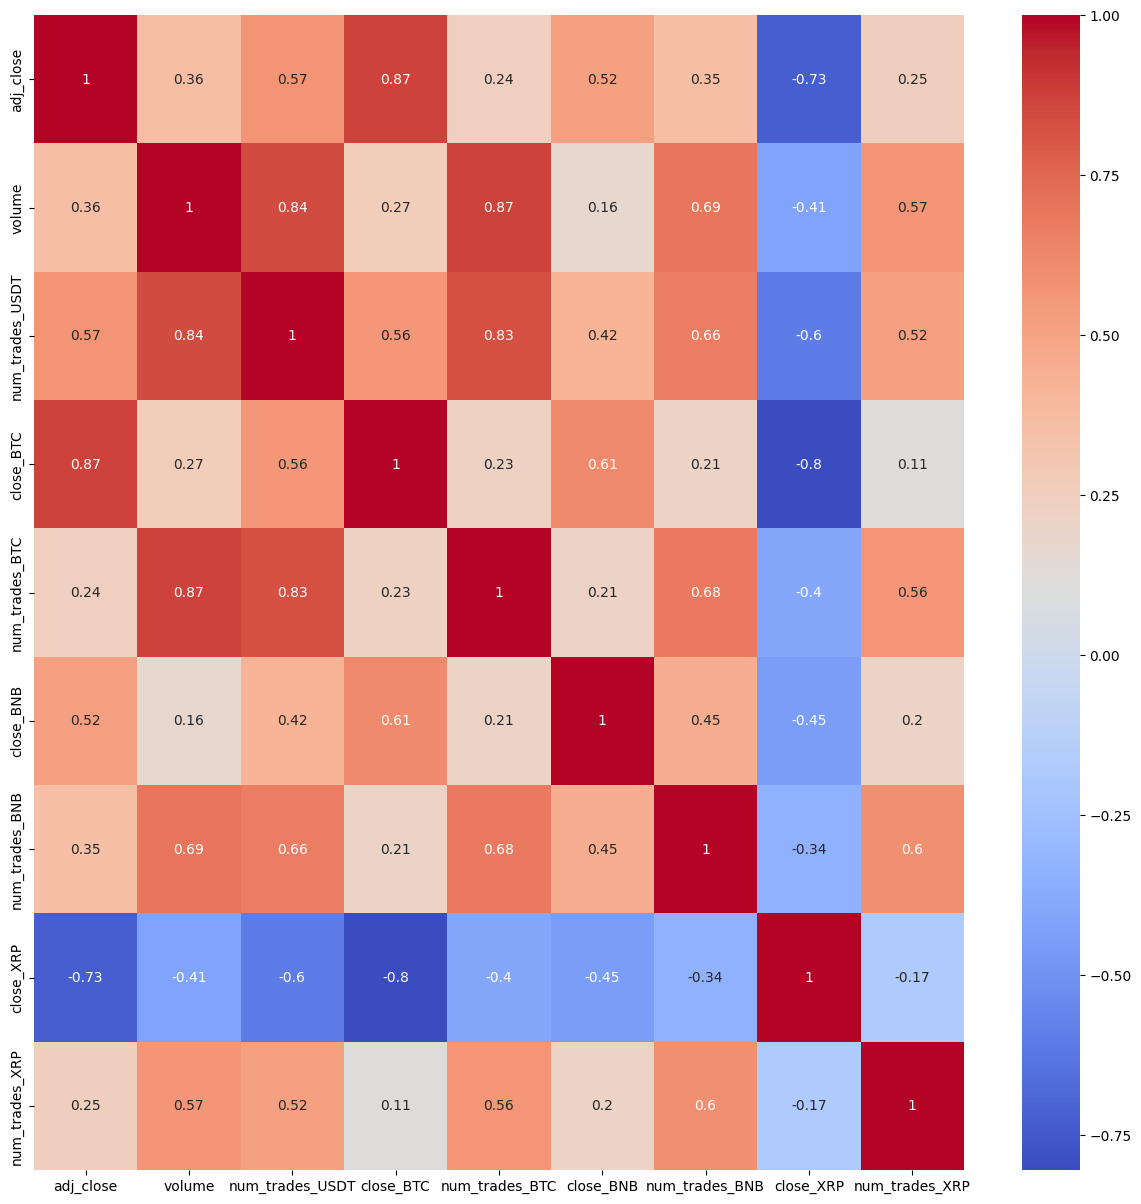

In [55]:
# check for correlation with heatmap
plt.figure(figsize=(15, 15))    
sns.heatmap(df_finance_norm.corr(), annot=True, cmap='coolwarm')

### Tokenization

In [56]:
# import dictionary.pickle 
with open('dictionary.pickle', 'rb') as handle:
    dictionary = pickle.load(handle)
# Dictionary structure: {word: token}

In [57]:
# check if a word is in dictionary
'sos' in dictionary

True

In [58]:
# when tokenizing we will convert the words to numbers
def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [dictionary[word] for word in tokens if word in dictionary]
    return tokens

lemmatizer = WordNetLemmatizer()

In [59]:
# test lemmatization
sentence = 'SOS I am going to the store to buy some apples EOS'
# make a 1 column dataframe with the sentence
df_sentence = pd.DataFrame([sentence], columns=['text'])

df_sentence.head()

,text
0,SOS I am going to the store to buy some apples EOS


In [60]:
df_sentence['text'] = df_sentence['text'].str.lower()
# if word not in dictionary, lemmatize it, else keep it as it is
df_sentence['text'] = df_sentence['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) if word not in dictionary else word for word in x.split()]))

df_sentence.head()

,text
0,sos i am going to the store to buy some apple eos


In [61]:
# tokenize all the dataframes in df_reddit_f
for df in df_reddit_f:
    for i in range(1, 11): # text_1 to text_10
        # make letters lowercase to work with dictionary
        df['text_' + str(i)] = df['text_' + str(i)].str.lower()
        # lemmatize the words to work with dictionary
        df['text_' + str(i)] = df['text_' + str(i)].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) if word not in dictionary else word for word in x.split()]))
        # tokenize the words
        df['tok_text_' + str(i)] = df['text_' + str(i)].apply(tokenize)

In [62]:
# print the first 5 rows of the first dataframe
df_reddit_f[0].head(5)

,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9,text_10,tok_text_1,tok_text_2,tok_text_3,tok_text_4,tok_text_5,tok_text_6,tok_text_7,tok_text_8,tok_text_9,tok_text_10
date,,,,,,,,,,,,,,,,,,,,
1/10/2019,"sos divi project update september 2019 month in review. great $divi september update. you guy have been keeping busy! i can’t wait for the mobile wallet. i heard your going to demo the mobile wallet at vega blockchain week. wish i could go!. if we want the world to use crypto, the technology need to be easy 2 use. thank god the team $divi is got that in mind. eos","sos interview with the ceo of divi geoff mccabe by the divi crypto podcast. it's unbelievable how true that is, if we expect the world to use cryptos... there's gotta be an easier option in the market for people to use.. sei grande @geoffreymccabe bravo!!!. **great** **interview** **geoff** eos","sos is wall street finally learning not to panic over crypto market volatility? recent price dip ha bloomberg saying ""buy!"".... . . eos","sos in china, a large mining farm burned down. damage exceeded $ 10 million |. . . eos","sos bitcoin bull run's 'likely target' is $200-300k, claim popular analyst. oh shut up. meh. eos","sos vaultoro integrates dash, relaunches gold-to-cryptocurrency trading platform. . . eos",sos flixxo's latest article on latam bonds. . . eos,sos block.one agrees to pay sec $24 million over unregistered eos ico. . . eos,sos altcoin news: shady coinexchange.io is closing down. . . eos,sos which cryptocurrency do you think will win the crypto race?. . . eos,"[1, 60, 61, 62, 63, 64, 65, 66, 67, 60, 63, 62, 68, 69, 70, 71, 72, 48, 73, 74, 75, 72, 48, 76, 28, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 83, 88, 89, 90, 67, 60, 91, 92, 2]","[1, 93, 94, 60, 95, 96, 60, 84, 97, 98, 99, 100, 82, 83, 101, 91, 102, 103, 104, 19, 105, 83, 106, 107, 108, 109, 66, 93, 95, 2]","[1, 110, 111, 112, 113, 114, 84, 19, 56, 115, 24, 116, 12421, 117, 118, 14, 2]","[1, 120, 121, 43, 122, 123, 124, 125, 67, 126, 2]","[1, 5, 10, 127, 129, 119, 67, 130, 131, 132, 133, 134, 135, 2]","[1, 136, 137, 138, 139, 140, 141, 2]","[1, 142, 143, 144, 145, 2]","[1, 147, 148, 149, 67, 126, 150, 2, 151, 2]","[1, 29, 152, 153, 154, 2]","[1, 13, 155, 49, 84, 156, 2]"
2/10/2019,sos popular ethereum app collapses: how many other dapps are vulnerable?. just one of many which illustrates why mass adoption will have issues. how do you trust someone you don’t know who can be in the other side of the planet and whose identity can be unknown? at least with a bank you can see them everyday for the most part and there are strict regulatory controls.. . eos,"sos top german bank predicts bitcoin to hit $90,000 after halving, calling it â€˜ultrahard moneyâ€™. . . eos",sos utrust integrates dash enabling cryptocurrency payment for whow game with 9 million users. . . eos,sos brazilian cryptocurrency exchange cointrade.cx add dash including instantsend support. . . eos,sos samsung-backed blocko launch in uae after dubai blockchain push. . . eos,sos speaker of the house challenger bacelar ha a crypto manifesto - the daily chain. . . eos,"sos altcoin news: a large german bank predicts a rise of bitcoin to $90,000. [removed]. . eos",sos trustee of mt.gox is interested in the case of alexander vinnik. . . eos,sos hong kong: why bitcoin volume have hit a record high. . . eos,sos us state of ohio suspends service for paying tax with bitcoin. . . eos,"[1, 131, 3, 157, 159, 160, 161, 162, 159, 163, 164, 165, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 2]","[1, 183, 184, 176, 185, 5, 186, 67, 40, 187, 188, 189, 2]","[1, 190, 137, 138, 191, 13, 192, 193, 194, 126, 2]","[1, 196, 13, 197, 198, 138, 199, 200, 201, 2]","[1, 202, 203, 204, 205, 28, 206, 2]","[1, 207, 208, 209, 210, 12421, 84, 211, 212, 213, 2]","[1, 29, 152, 121, 184, 176, 185, 20, 5, 67, 214, 2]","[1, 215, 216, 217, 218, 219, 2]","[1, 220, 221, 5, 25, 186, 222, 31, 2]","[1, 2779, 224, 225, 226, 227, 228, 229, 

we added the tokenized text to 10 new columns

we can later drop the original text columns, keeping them for analysis

In [63]:
# print the words for the tokens of a news article
list_nums = [1, 110, 111, 112, 113, 114, 84, 19, 56, 115, 24, 116, 117, 118, 14, 2]
for num in list_nums:
    for key, value in dictionary.items():
        if value == num:
            print(key)

sos
wall
street
finally
learning
panic
crypto
market
volatility
recent
price
dip
bloomberg
saying
buy
eos


In [64]:
# find average length of tokenized news
def avg_len(df):
    sum = 0
    for i in range(1, 11):
        sum += df['tok_text_' + str(i)].str.len().sum()
    return sum / (len(df) * 10)

def min_len(df):
    min = 100000
    for i in range(1, 11):
        if df['tok_text_' + str(i)].str.len().min() < min:
            min = df['tok_text_' + str(i)].str.len().min()
    return min

def max_len(df):
    max = 0
    for i in range(1, 11):
        if df['tok_text_' + str(i)].str.len().max() > max:
            max = df['tok_text_' + str(i)].str.len().max()
    return max

for df in df_reddit_f:
    print('avg: {:.2f}'.format(avg_len(df)) + ', min: ' + str(min_len(df)) + ', max: ' + str(max_len(df)))


avg: 12.77, min: 2, max: 305
avg: 14.18, min: 2, max: 367
avg: 37.09, min: 2, max: 641
avg: 15.89, min: 2, max: 470
avg: 21.60, min: 2, max: 861
avg: 38.26, min: 2, max: 1546
avg: 25.49, min: 2, max: 727


In [65]:
# we have df_reddit_f which is a list of 7 dataframes
# we want to make a copy of df_reddit_f to work with
df_reddit_f_copy = df_reddit_f.copy()

fixes needed in following part

we want to pad the tokens to a fixed length, so we can use them in a neural network

we can have a different padding length for each dataframe, as we will only use one at a time

keep the padding length close (a bit higher) to the average length of the tokens for each dataframe, you can see these lengths above

In [66]:
# 0 padding to make all the news the same length
def pad(df, max_len):
    for i in range(1, 11):
        # save the tokenized news in a new column
        # pad and truncate the news to max_len
        df['tok_text_' + str(i)] = pad_sequences(df['tok_text_' + str(i)], maxlen=max_len, padding='post', truncating='post')

In [67]:
# padding and truncating for df_reddit_f_copy[0]
for i in range(1, 11):
    # create empty tok_text_i_pad column
    df_reddit_f_copy[1]['tok_text_' + str(i)] = pad_sequences(df_reddit_f_copy[1]['tok_text_' + str(i)], maxlen=15, padding='post', truncating='post')

# pad(df_reddit_f[0], 15)
# pad(df_reddit_f[1], 15)
# pad(df_reddit_f[2], 35)
# pad(df_reddit_f[3], 15)
# pad(df_reddit_f[4], 25)
# pad(df_reddit_f[5], 35)
# pad(df_reddit_f[6], 25)

# print the first 5 rows of the first dataframe
df_reddit_f[1].head()

,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9,text_10,tok_text_1,tok_text_2,tok_text_3,tok_text_4,tok_text_5,tok_text_6,tok_text_7,tok_text_8,tok_text_9,tok_text_10
date,,,,,,,,,,,,,,,,,,,,
1/10/2019,sos how to automate your crypto portfolio with trading scripts. [deleted]. . eos,"sos altcoin news: british police bailed out $294,000 from the sale of confiscated cryptocurrency at auction. . . eos","sos dash drop to #19 on cmc, surpassed by #tezos and #chainlink. investor put a proposal to replace marketing director. supervisor at @dashinvests call the proposal ""ridiculous"" and ""meaningless"". director at @dashpay tell masternodes to ""not give a decision"" and ""let it die"".. follow the shit-show proposal to replace the chief marketing director: [https://www.dashcentral.org/p/fernando-cmo](https://www.dashcentral.org/p/fernando-cmo) proposal to replace the moderator of r/dashpay [https://www.dashcentral.org/p/macrochip-basilpop](https://www.dashcentral.org/p/macrochip-basilpop) fluffypony's tweet: [https://twitter.com/fluffypony/status/1178860589810143232?s=20](https://twitter.com/fluffypony/status/1178860589810143232?s=20). oh god lol, what a fucking mess. guess masternodes weren't such a revolutionary fix-all after all. eos",sos morningstar to start rating cryptocurrencies. . . eos,sos 4 way blockchain can improve the life of people in developing countries. . . eos,sos bakkt future exchange see notable drop in trading volume today. . . eos,"sos latest news episode is out: is xrp a security?, what is the crypto rating council?, binance announces market maker program. . . eos",sos the social network for the crypto world! ...and of course - it pay you to use it!. . . eos,sos for beginners: compilation of the platform and people in the crypto and blockchain world. . . eos,sos analyzing different type of cryptocurrency wallets. . . eos,1,1,1,1,1,1,1,1,1,1
2/10/2019,"sos binance freeze 12 billion trx, vote itself into tron super representative top-spot. i'm not a type of person to throw word around lightly. but what realworld word best describe what happened?. they're not even trying to hide the manipulation anymore.. eos",sos russian ministry of finance proposes 3 legal category for cryptocurrencies. . . eos,sos popular ethereum app collapses: how many other dapps are vulnerable?. misleading title. fairwin wa an actual scam with a fake team. nothing suggests any common vulnerability in eth dapps.. . eos,"sos german bank predicts bitcoin at 90000 usd by 2020, bakkt traded 5 million on the first week. . . eos",sos buy and sell bitcoin with no kyc in europe. hmm. ok. . eos,sos credit trading competition. . . eos,"sos mark zuckerberg say libra is being tested in india. i'm not supporting him, i find him the most dangerous person of 21st century, the reason why he made libra is 'it will allow him to know how much money each person has', this is nothing but another way to attack on user privacy. i strongly support privacy and i believe any platform which give privacy to user will perform well in future like brave browser, monero and vid app.. rihdansnbqipdmah3vx5quq6s4ix8e3g. [removed] eos",sos cryptocurrency fund trapped by 'decentralized exchange' pending kyc checks. . . eos,sos altcoin news: visa and mastercard reconsider participation in libra. . . eos,"sos altcoin news: a large german bank predicts a rise of bitcoin to $90,000. sound like a fairy tale. . eos",1,1,1,1,1,1,1,1,1,1
3/10/2019,"sos brave web browser user base grows by 10% monthly brendan eich says. isn't it a good news? i think people have started realizing that brave is better than chrome and other browser haha. the reason why people are using brave is because it is giving privacy to users. in next decade privacy platform like brave browser, vid app and others will take over the market.. i like brave browser, i even have it integrated with my website [leveluplighters.com](https://www.leveluplighters.com). they are one of the best blockchain projec